[Reference](https://thecleverprogrammer.com/2020/08/02/gender-classification-model/)

[Data](https://www.kaggle.com/ruizgara/socofing)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install seaborn tensorflow opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

import os
import cv2

import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [4]:
# Helper Functions

def extract_label(img_path,train = True):
  filename, _ = os.path.splitext(os.path.basename(img_path))

  subject_id, etc = filename.split('__')
  
  if train:
      gender, lr, finger, _, _ = etc.split('_')
  else:
      gender, lr, finger, _ = etc.split('_')
  
  gender = 0 if gender == 'M' else 1
  lr = 0 if lr == 'Left' else 1

  if finger == 'thumb':
      finger = 0
  elif finger == 'index':
      finger = 1
  elif finger == 'middle':
      finger = 2
  elif finger == 'ring':
      finger = 3
  elif finger == 'little':
      finger = 4
  return np.array([gender], dtype=np.uint16)

In [5]:
img_size = 96

def loading_data(path,train):
    print("loading data from: ",path)
    data = []
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (img_size, img_size))
            label = extract_label(os.path.join(path, img),train)
            data.append([label[0], img_resize ])
        except Exception as e:
            pass
    # data
    return data

In [6]:
Real_path = "/kaggle/input/socofing/SOCOFing/Real"
Easy_path = "/kaggle/input/socofing/SOCOFing/Altered/Altered-Easy"
Medium_path = "/kaggle/input/socofing/SOCOFing/Altered/Altered-Medium"
Hard_path = "/kaggle/input/socofing/SOCOFing/Altered/Altered-Hard"


Easy_data = loading_data(Easy_path, train = True)
Medium_data = loading_data(Medium_path, train = True)
Hard_data = loading_data(Hard_path, train = True)
test = loading_data(Real_path, train = False)

data = np.concatenate([Easy_data, Medium_data, Hard_data], axis=0)
# data = Easy_data + Medium_data + Hard_data

del Easy_data, Medium_data, Hard_data

loading data from:  /kaggle/input/socofing/SOCOFing/Altered/Altered-Easy
loading data from:  /kaggle/input/socofing/SOCOFing/Altered/Altered-Medium
loading data from:  /kaggle/input/socofing/SOCOFing/Altered/Altered-Hard
loading data from:  /kaggle/input/socofing/SOCOFing/Real


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [7]:
# randomize the data and test the arrays 
import random
random.shuffle(data)
random.shuffle(test)

In [8]:
# split the image arrays and image labels:
img, labels = [], []
for label, feature in data:
    labels.append(label)
    img.append(feature)
train_data = np.array(img).reshape(-1, img_size, img_size, 1)
train_data = train_data / 255.0

In [9]:
# Building CNN for Gender Classification Model
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = Sequential(
    [
        Conv2D(32, 3, padding='same', activation='relu',kernel_initializer='he_uniform', input_shape = [96, 96, 1]),
        MaxPooling2D(2),
        Conv2D(32, 3, padding='same', kernel_initializer='he_uniform', activation='relu'),
        MaxPooling2D(2),
        Flatten(),
        Dense(128, kernel_initializer='he_uniform',activation = 'relu'),
        Dense(2, activation = 'softmax'),
    ]
)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 128)               2

In [11]:
# compile the model using Adam optimizers, with a learning rate of 10%, and to prevent our CNN model from overfitting, I will be using the early_stopping_call method
loss_func = 'categorical_crossentropy' #"binary_crossentropy" #'
model.compile(optimizer = optimizers.Adam(1e-3), loss = loss_func, metrics = ['accuracy'])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [12]:
# np.unique(train_labels)

from keras.utils import to_categorical
import numpy as np

train_labels = labels

train_data = np.array(train_data)
train_labels = np.array(train_labels)

# Convert labels to one-hot vectors
train_labels = to_categorical(train_labels)


In [13]:
# fit our Gender Classification Model, We are going to train the model for 30 epochs


history = model.fit(train_data, train_labels, batch_size = 128, epochs = 30, 
          validation_split = 0.2, callbacks = [early_stopping_cb], verbose = 1)

Epoch 1/30
308/308 [==============================] - 14s 19ms/step - loss: 0.7595 - accuracy: 0.7722 - val_loss: 0.4515 - val_accuracy: 0.8086
Epoch 2/30
308/308 [==============================] - 5s 15ms/step - loss: 0.4242 - accuracy: 0.8178 - val_loss: 0.3535 - val_accuracy: 0.8409
Epoch 3/30
308/308 [==============================] - 4s 14ms/step - loss: 0.3582 - accuracy: 0.8450 - val_loss: 0.3023 - val_accuracy: 0.8723
Epoch 4/30
308/308 [==============================] - 5s 15ms/step - loss: 0.2777 - accuracy: 0.8884 - val_loss: 0.2494 - val_accuracy: 0.9084
Epoch 5/30
308/308 [==============================] - 5s 15ms/step - loss: 0.2037 - accuracy: 0.9219 - val_loss: 0.1991 - val_accuracy: 0.9196
Epoch 6/30
308/308 [==============================] - 5s 15ms/step - loss: 0.1329 - accuracy: 0.9551 - val_loss: 0.1799 - val_accuracy: 0.9241
Epoch 7/30
308/308 [==============================] - 4s 14ms/step - loss: 0.0887 - accuracy: 0.9730 - val_loss: 0.1244 - val_accuracy: 0.953

(0.0, 1.0)

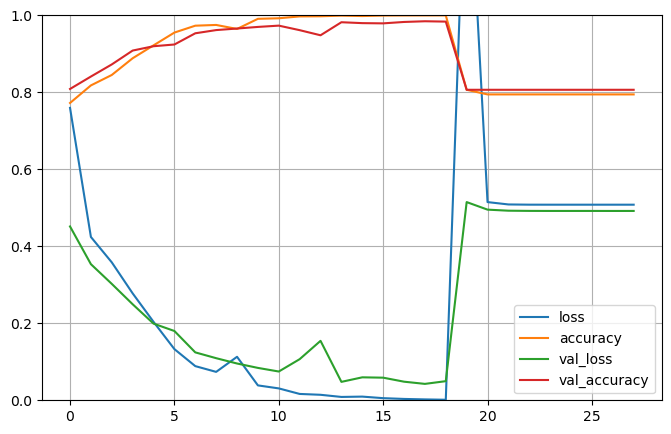

In [14]:
# Visualizing model performance
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)

In [15]:
# Testing Gender Classification Model

test_images, test_labels = [], []

for label, feature in test:
    test_images.append(feature)
    test_labels.append(label)
    
test_images = np.array(test_images).reshape(-1, img_size, img_size, 1)
test_images = test_images / 255.0
del test
test_labels  = to_categorical(test_labels, num_classes = 2)

In [16]:
model.evaluate(test_images, test_labels)

188/188 [==============================] - 1s 4ms/step - loss: 0.5073 - accuracy: 0.7950


[0.507260262966156, 0.7950000166893005]

In [17]:
# Save the model
model.save("/kaggle/working/model.h5")


In [18]:
# Save the model architecture as JSON
model_json = model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights
model.save_weights("model_weights.h5")
